# Modelos

Este modelo es un regresor, utilizando como target la propina por km. Es un modelo base, introduciendo los datos tal cual, y sin realizar previamente una clasificación.

In [15]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Machine learning supervisado
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, make_scorer, recall_score, precision_score
import xgboost

# Transformación logarítmica
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Guardar modelos
# ==============================================================================
import pickle


### Carga de datos

In [16]:
df = pd.read_csv('../../data/df_yellowtaxi_cleaned.csv', index_col='Unnamed: 0')
df_zones = pd.read_csv('../../data/taxi_zone_geo.csv')

In [17]:
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,pickup_DoW_name,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tolls_percentage,tip_amount
1,2.0,3.76506,1.0,236,233,1,14.2,True,2.5,0.00,4,Friday,00:18:40,0,708.0,11.898305,0.0,2.00
2,1.0,2.60658,1.0,162,236,1,8.6,True,2.5,0.00,4,Friday,00:35:01,0,243.0,24.000000,0.0,2.00
4,1.0,15.84865,1.0,138,230,1,45.0,True,2.5,1.75,4,Friday,00:01:23,0,2202.0,16.103542,0.0,17.02
7,1.0,6.27510,1.0,140,7,1,20.5,True,2.5,0.00,4,Friday,00:01:04,0,1052.0,13.346008,0.0,6.35
8,2.0,4.34430,1.0,45,164,1,16.3,True,2.5,0.00,4,Friday,00:37:44,0,880.0,11.045455,0.0,4.26


Se crea la variable target para el regresor, que se va a llamar tip_per_km.

In [18]:
df['tip_per_km'] = df['tip_amount'] / df['trip_distance']

In [19]:
# Transformo también fare_amount y tolls_pct para que estén en función de la distancia
df['fare_amount_per_km'] = df['fare_amount'] / df['trip_distance']
df['toll_per_km'] = df['tolls_percentage'] * df['fare_amount'] / df['trip_distance']    # Tolls percentage era la cantidad de toll dividida por el fare, por lo tanto para obtener el toll_per_km, multiplicamos por fare_amount y dividimos por la distancia
df.drop(columns = ['fare_amount','tolls_percentage'], inplace = True)

Para este modelo, se va a realizar un target encoding de las variable PULocationID y DOLocationID, asignando a cada zona la proporcion de tips de mas de 2€/km, aplicandoun suavizado, que ayuda a evitar que las zonas con pocos datos (es decir, con pocas observaciones) tengan proporciones
 poco confiables o extremas.    
Para zonas con pocos viajes, las proporciones extremas se moderan acercándolas a la proporción global.
Para zonas con suficientes viajes, las proporciones se mantienen similares a las proporciones observadas en los datos.

In [20]:
# Factor de suavizado
m = 20  

# Porcentaje global de propinas >2$/km
global_high_tip_pct = (df['tip_per_km'] >= 2).mean()

# Calcular el porcentaje de propinas >2$/km por zona y el número de registros por zona
zone_stats = df.groupby('PULocationID')['tip_per_km'].agg(
    high_tip_pct=lambda x: (x > 2).mean(),  # Porcentaje de propinas >10$
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_high_tip_pct'] = (
    (zone_stats['count'] * zone_stats['high_tip_pct'] + m * global_high_tip_pct) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['PULocationEncoded'] = df['PULocationID'].map(zone_stats.set_index('PULocationID')['smoothed_high_tip_pct'])

# Se aplica el mismo procedimiento para las ubicaciones de dropoff:
# Factor de suavizado
m = 20  

# Porcentaje global de propinas >2$/km
global_high_tip_pct = (df['tip_per_km'] >= 2).mean()

# Calcular el porcentaje de propinas >2$/km por zona y el número de registros por zona
zone_stats = df.groupby('DOLocationID')['tip_per_km'].agg(
    high_tip_pct=lambda x: (x > 2).mean(),  # Porcentaje de propinas >10$
    count='count'  # Número de registros
).reset_index()

# Aplicar el suavizado
zone_stats['smoothed_high_tip_pct'] = (
    (zone_stats['count'] * zone_stats['high_tip_pct'] + m * global_high_tip_pct) /
    (zone_stats['count'] + m)
)

# Mapear el porcentaje suavizado a la columna original
df['DOLocationEncoded'] = df['DOLocationID'].map(zone_stats.set_index('DOLocationID')['smoothed_high_tip_pct'])
df.head()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,mta_tax,congestion_surcharge,Airport_fee,pickup_DoW,...,pickup_Timestamp,pickup_Time,trip_duration,avg_speed(km/h),tip_amount,tip_per_km,fare_amount_per_km,toll_per_km,PULocationEncoded,DOLocationEncoded
1,2.0,3.76506,1.0,236,233,1,True,2.5,0.00,4,...,00:18:40,0,708.0,11.898305,2.00,0.531200,3.771520,0.0,0.099129,0.114796
2,1.0,2.60658,1.0,162,236,1,True,2.5,0.00,4,...,00:35:01,0,243.0,24.000000,2.00,0.767289,3.299342,0.0,0.132833,0.088643
4,1.0,15.84865,1.0,138,230,1,True,2.5,1.75,4,...,00:01:23,0,2202.0,16.103542,17.02,1.073909,2.839359,0.0,0.003161,0.197021
7,1.0,6.27510,1.0,140,7,1,True,2.5,0.00,4,...,00:01:04,0,1052.0,13.346008,6.35,1.011936,3.266880,0.0,0.094130,0.006271
8,2.0,4.34430,1.0,45,164,1,True,2.5,0.00,4,...,00:37:44,0,880.0,11.045455,4.26,0.980595,3.752043,0.0,0.074915,0.161863


 Como el dataset tiene una gran cantidad de datos, se va a realizar un muestreo para reducir el tiempo de entrenamiento de los modelos y agilizar el trabajo. En este caso se va a realizar un muestreo aleatorio


In [21]:
# Muestreo aleatorio de la clase mayoritaria
df_sampled = df.sample(n=int(0.25*len(df)), random_state=42)
   # con el .sample se mezclan las filas para que no queden ordenadas, ya que al hacer merge quedaron primero todas las de una categoría y luego las de la otra

# Redefinir X e y
X = df_sampled.drop(columns=['tip_per_km', 'RatecodeID', 'payment_type', 'mta_tax', 'pickup_Timestamp', 'pickup_DoW_name', 'DOLocationID', 'PULocationID'])
y = df_sampled['tip_per_km']

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Guardar las columnas originales para poder hacer el score con tip_amount
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

X_train.drop(columns ='tip_amount', inplace = True )
X_test.drop(columns ='tip_amount', inplace = True )

La métrica que se va a utilizar para evaluar el modelo es el MAE de la cantidad de propina total

In [22]:
# Crear el pipeline con XGBRegressor
pipe = Pipeline(steps=[
    ('regressor', xgboost.XGBRegressor())
])

# Definir el espacio de búsqueda para XGBRegressor
xgboost_param = {
    'regressor__n_estimators': [200, 300, 400],  # Número de árboles
    'regressor__learning_rate': [0.008, 0.01, 0.03, 0.05],  # Tasa de aprendizaje
    'regressor__max_depth': [3, 5, 7, 10]  # Profundidad máxima
}

# Crear un scorer para MAE (nota que usamos el signo negativo para optimización)
mae_scorer = make_scorer(metrics.mean_absolute_error, greater_is_better=False)

# Configurar RandomizedSearchCV
rgr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=xgboost_param,  # Espacio de búsqueda para XGBregressor
    n_iter=10,  # Número de combinaciones a probar
    scoring=mae_scorer,  # Métrica de evaluación (F2 Score)
    random_state=42  # Semilla para reproducibilidad
)

# Entrenar el modelo
rgr.fit(X_train, y_train)

# Mostrar los mejores parámetros y modelo
print("Best Parameters:", rgr.best_params_)
print("Best Model:", rgr.best_estimator_)

# Evaluar en el conjunto de entrenamiento
y_pred_train = rgr.best_estimator_.predict(X_train)
y_pred_train_total = y_pred_train * X_train_orig['trip_distance']  # Reconstruir la propina total
mae_train = round(metrics.mean_absolute_error(X_train_orig['tip_amount'], y_pred_train_total), 3)
print("MAE (Train):", mae_train)

# Evaluar en el conjunto de prueba
y_pred = rgr.best_estimator_.predict(X_test)
y_pred_total = y_pred * X_test_orig['trip_distance']  # Reconstruir la propina total
mae_test = round(metrics.mean_absolute_error(X_test_orig['tip_amount'], y_pred_total), 3)
print("MAE (Test):", mae_test)

Best Parameters: {'regressor__n_estimators': 250, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Best Model: Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                

In [23]:
# Calcular métricas
mae = metrics.mean_absolute_error(X_test_orig['tip_amount'], y_pred_total)
mse = metrics.mean_squared_error(X_test_orig['tip_amount'], y_pred_total)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(X_test_orig['tip_amount'], y_pred_total)

# Reportar resultados
print("Regression Metrics Report")
print("-------------------------")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Regression Metrics Report
-------------------------
Mean Absolute Error (MAE): 1.460
Mean Squared Error (MSE): 7.360
Root Mean Squared Error (RMSE): 2.713
R² Score: 0.580


Feature Importances:
                 Feature  Importance
8     fare_amount_per_km    0.599413
1          trip_distance    0.230811
2   congestion_surcharge    0.074566
9            toll_per_km    0.019489
4             pickup_DoW    0.016019
5            pickup_Time    0.015823
6          trip_duration    0.011597
10     PULocationEncoded    0.011540
7        avg_speed(km/h)    0.006927
3            Airport_fee    0.004908
11     DOLocationEncoded    0.004569
0        passenger_count    0.004338


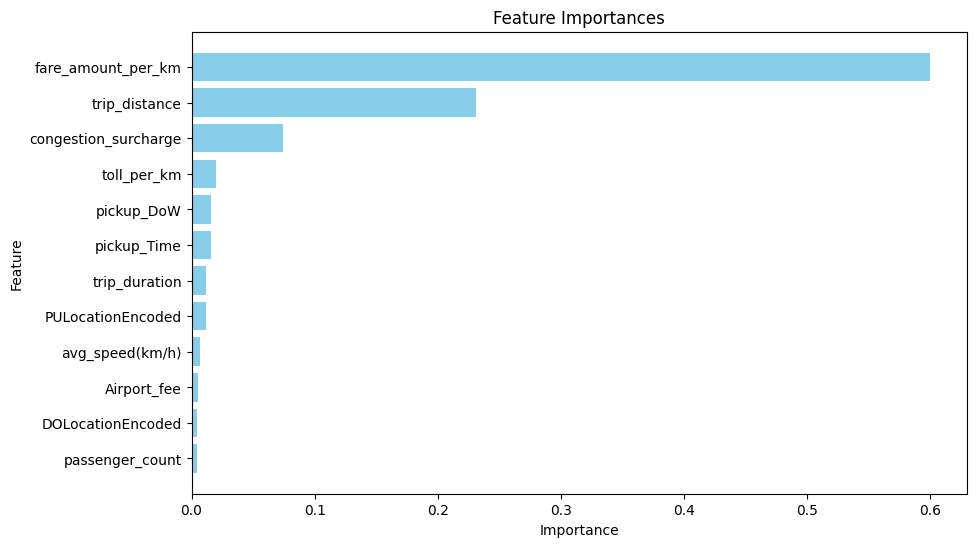

In [24]:
# Obtener el modelo final del mejor pipeline
best_model = rgr.best_estimator_.named_steps['regressor']

# Verificar el tipo de modelo y calcular las importancias
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("Feature Importances:")
    print(importance_df)

    # Graficar las importancias
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("El modelo seleccionado no soporta cálculo de importancias de características.")


Este modelo mejora el recall respecto al anterior

In [25]:
# Guardamos el modelo en un archivo con pickle
with open('regressor_1.pkl', 'wb') as file:
    pickle.dump(rgr.best_estimator_, file)

print("Modelo guardado como 'regressor_1.pkl'")

Modelo guardado como 'regressor_1.pkl'
